In [25]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
transform = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor(), #numpy array of range 0-255 --> float tensor of range 0-1
transforms.Normalize((.5,), (.5,))]) # norm. vals for each tensor of image size: channel, h, w. first bracket: mean val to normalise all channels in tensor image. second: SD. want range of 0-1 and -1-0
# reduces skewness and distorions is data - more effective learning

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) #subset of training data. changes if shuffle - prevents getting caught in local minima
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [59]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    #image = image.to(device)
    image = image.transpose(1,2,0) #MNIST - greyscale, 28*28px = 28*28*1 tensor. transpose tensor from c,w,h to w,h,c
    #print(image.shape)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denorm.
    image = image.clip(0, 1) #make sure range is back to 0-1, vs -1-1
    return image

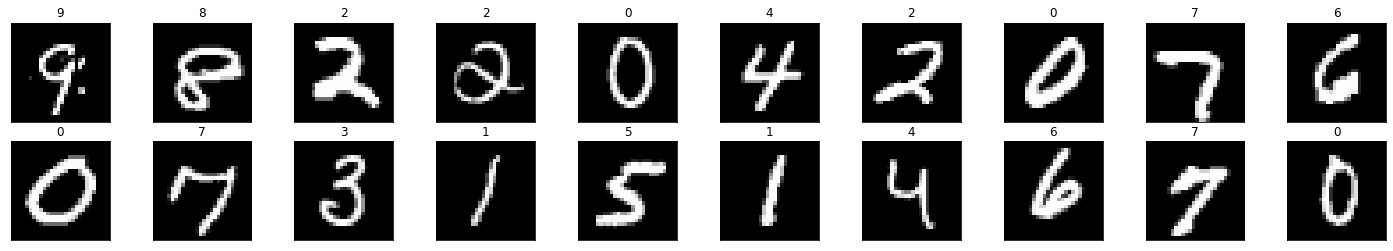

In [28]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4)) # w x h

for index in np.arange(20):
    ax = fig.add_subplot(2, 10, index + 1, xticks=[], yticks=[]) # r, c, index: pos. of subplot 
    plt.imshow(img_convert(images[index]))
    ax.set_title(labels[index].item())

In [40]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) #input channels (1 for grey), output, kernel size, stride length
        self.conv2 = nn.Conv2d(20, 50, 5, 1) #ie depth of 50 in nxt conv.
        self.fc1 = nn.Linear(4*4*50, 500) #28 original, kernel 5, first conv = 24, halved in pool1 = 12, conv2 = 8, pool2 = 4. 50 out channels in preceeding layer, so imgsize*channels. 500 output nodes
        self.dropout1 = nn.Dropout(0.5) #dropout rate
        self.fc2 = nn.Linear(500, 10) #10 classes in MNIST
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) #2*2 size of max pooling kernel ie halves
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50) #reshape - flattened for fcl. col*row. 2: output shape of data from prev maxpool layer
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) #between fcls since high parameter layers - more likely to overfit and memorise training layer
        x = self.fc2(x) #multiclass data set so no activ func on last layer - passed via cross entropy loss
        return x

In [41]:
model = LeNet().to(device)
model
#model.to(device)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [42]:
criterion = nn.CrossEntropyLoss() #for classification problems with n clases
optimiser = torch.optim.Adam(model.parameters(), lr = .0001)

In [43]:
epochs = 15
running_loss_history = []
running_corrects_history = [] #accuracy per epoch
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = .0
    running_corrects = .0
    val_running_loss = .0
    val_running_corrects = .0
    

    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #inputs = inputs.view(inputs.shape[0], -1) #full 28*28 passed in to be convulved by kernel so line not required
        outputs = model(inputs) #scores
        loss = criterion(outputs, labels)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        _, preds = torch.max(outputs, 1) #top score per image. highest score in index x --> predict image belongs to class x
        running_corrects += torch.sum(preds == labels.data) #cmp to labels. if matching return 1 else 0. total
        running_loss += loss.item()


    else:
        with torch.no_grad(): #testing not training
            for val_inputs, val_labels in validation_loader:
                #val_inputs = val_inputs.view(val_inputs.shape[0], -1) #full 28*28 passed in to be convulved by kernel so line not required
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()


        epoch_loss = running_loss / len(training_loader)
        epoch_acc  = running_corrects.float() / len(training_loader) #no. batches
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc  = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss) # loss at every epoch
        val_running_corrects_history.append(val_epoch_acc)

        print("epoch :", (e+1))
        print("training loss: {:.4f}, acc {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, acc {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

epoch :1
training loss: 0.5732, acc 85.1867
validation loss: 0.1755, acc 95.0100
epoch :2
training loss: 0.1461, acc 95.6750
validation loss: 0.1073, acc 96.8200
epoch :3
training loss: 0.0996, acc 97.0517
validation loss: 0.0774, acc 97.6000
epoch :4
training loss: 0.0777, acc 97.6667
validation loss: 0.0667, acc 97.8800
epoch :5
training loss: 0.0653, acc 98.0100
validation loss: 0.0506, acc 98.4200
epoch :6
training loss: 0.0558, acc 98.3450
validation loss: 0.0474, acc 98.5300
epoch :7
training loss: 0.0489, acc 98.4867
validation loss: 0.0422, acc 98.6200
epoch :8
training loss: 0.0456, acc 98.6250
validation loss: 0.0384, acc 98.7500
epoch :9
training loss: 0.0396, acc 98.7983
validation loss: 0.0343, acc 98.8600
epoch :10
training loss: 0.0359, acc 98.9083
validation loss: 0.0296, acc 99.1200
epoch :11
training loss: 0.0340, acc 98.9817
validation loss: 0.0325, acc 98.9200
epoch :12
training loss: 0.0302, acc 99.0633
validation loss: 0.0323, acc 98.9700
epoch :13
training loss: 

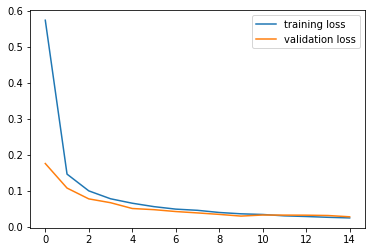

In [44]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

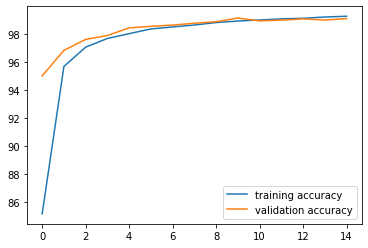

In [45]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

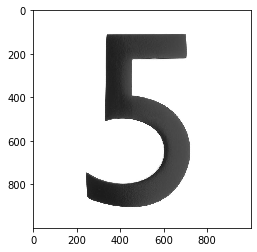

In [55]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

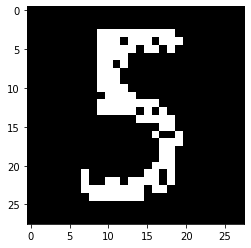

In [56]:
img = PIL.ImageOps.invert(img)
img = img.convert('1') # bilevel image?
img = transform(img)
plt.imshow(img_convert(img))

In [57]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0) #new tensor of dim 1 inserted at 0, x2
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


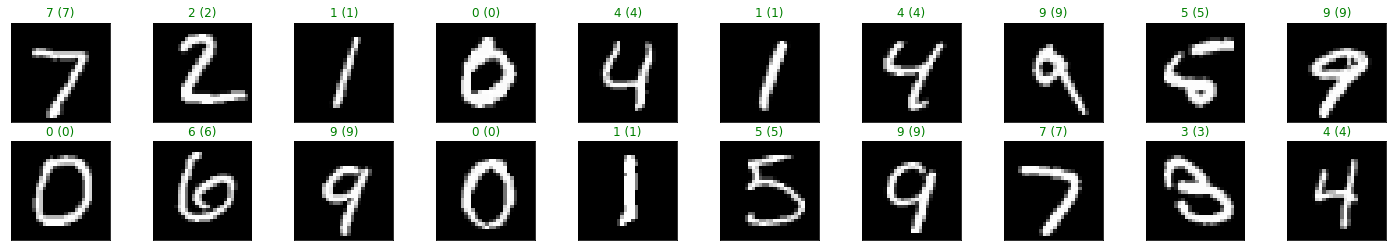

In [60]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4)) # w x h

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ("green" if preds[idx] == labels[idx] else "red"))